In [1]:
pwd

'/home/pranshumaan'

In [2]:
cd /media/pranshumaan/TOSHIBA\ EXT

/media/pranshumaan/TOSHIBA EXT


In [3]:
cd Dev/Deep_Learning_Pytorch_Udemy_Tutorial/

/media/pranshumaan/TOSHIBA EXT/Dev/Deep_Learning_Pytorch_Udemy_Tutorial


In [4]:
cd Paper_Replication/

/media/pranshumaan/TOSHIBA EXT/Dev/Deep_Learning_Pytorch_Udemy_Tutorial/Paper_Replication


In [5]:
ls

2010.11929.pdf  data/  going_modular/  helper_functions.py


## Replicating Vision Transformer (ViT) architecture paper in Pytorch

#### Importing prewritten code and helper functions

In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
# try:
#     from torchinfo import summary
# except:
#     print("[INFO] Couldn't find torchinfo... installing it.")
#     !pip install -q torchinfo
#     from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

#### Loading image data

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
device

'cuda'

In [9]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [10]:
!tree

.
├── 2010.11929.pdf
├── data
│   └── pizza_steak_sushi
│       ├── test
│       │   ├── pizza
│       │   │   ├── 1152100.jpg
│       │   │   ├── 1503858.jpg
│       │   │   ├── 1687143.jpg
│       │   │   ├── 1925494.jpg
│       │   │   ├── 194643.jpg
│       │   │   ├── 195160.jpg
│       │   │   ├── 2003290.jpg
│       │   │   ├── 2019408.jpg
│       │   │   ├── 2111981.jpg
│       │   │   ├── 2124579.jpg
│       │   │   ├── 2218680.jpg
│       │   │   ├── 2236338.jpg
│       │   │   ├── 2508636.jpg
│       │   │   ├── 2871261.jpg
│       │   │   ├── 3092704.jpg
│       │   │   ├── 309892.jpg
│       │   │   ├── 344397.jpg
│       │   │   ├── 3475871.jpg
│       │   │   ├── 398345.jpg
│       │   │   ├── 416067.jpg
│       │   │   ├── 540882.jpg
│       │   │   ├── 648055.jpg
│       │   │   ├── 714866.jpg
│       │   │   ├── 930553.jpg
│       │   │   └── 971934.jpg
│       │   ├── steak
│       │   │   ├── 100274.jpg
│       │   │   ├── 1016217.jpg
│       │   │   ├── 1285886.jpg

In [11]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [12]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()])

print(f"Manually created transform: {manual_transforms}")

Manually created transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [13]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE
                                                                              )
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

#### Visualizing a single image

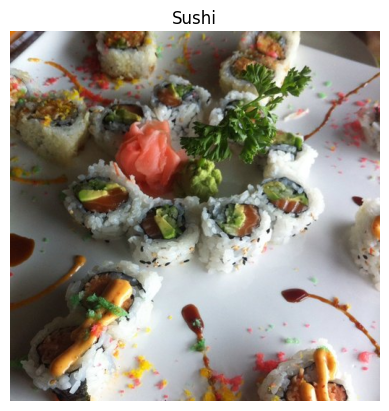

In [14]:
import random
from PIL import Image

random_image_file = random.choice(train_dataloader.dataset.samples)
random_image = random_image_file[0]
random_image_label = class_names[random_image_file[1]]

with Image.open(random_image) as im:
    plt.imshow(im)
    plt.axis('off')
    plt.title(random_image_label.title())

#### Split image into patches and create the class, position and patch embedding

In [15]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int(((height*width)/patch_size**2))
number_of_patches

196

In [16]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2*color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


In [17]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

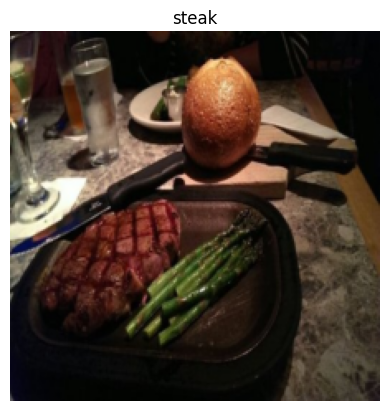

In [18]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [19]:
image.shape

torch.Size([3, 224, 224])

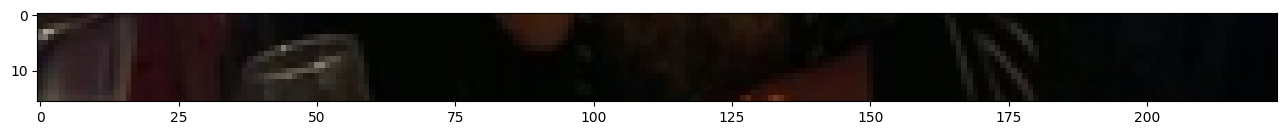

In [20]:
image_permuted = image.permute(1,2,0) # color channels first, HxWxC

patch_size = 16
plt.figure(figsize = (patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

>It's all about the embedding

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


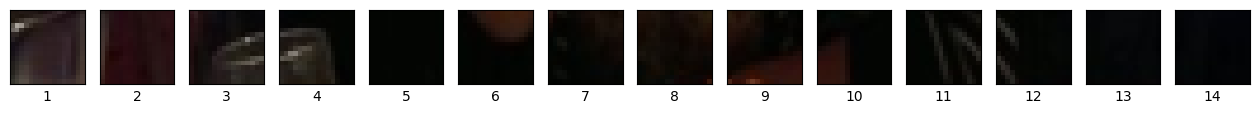

In [21]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0 #image size must be divisible by patch size

print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")
fig, axs = plt.subplots(nrows = 1,
                        ncols = int(img_size / patch_size),
                        sharex = True,
                        sharey= True,
                        figsize=(patch_size,patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [22]:
enumerate(range(0, img_size, patch_size)).__next__()

(0, 0)

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


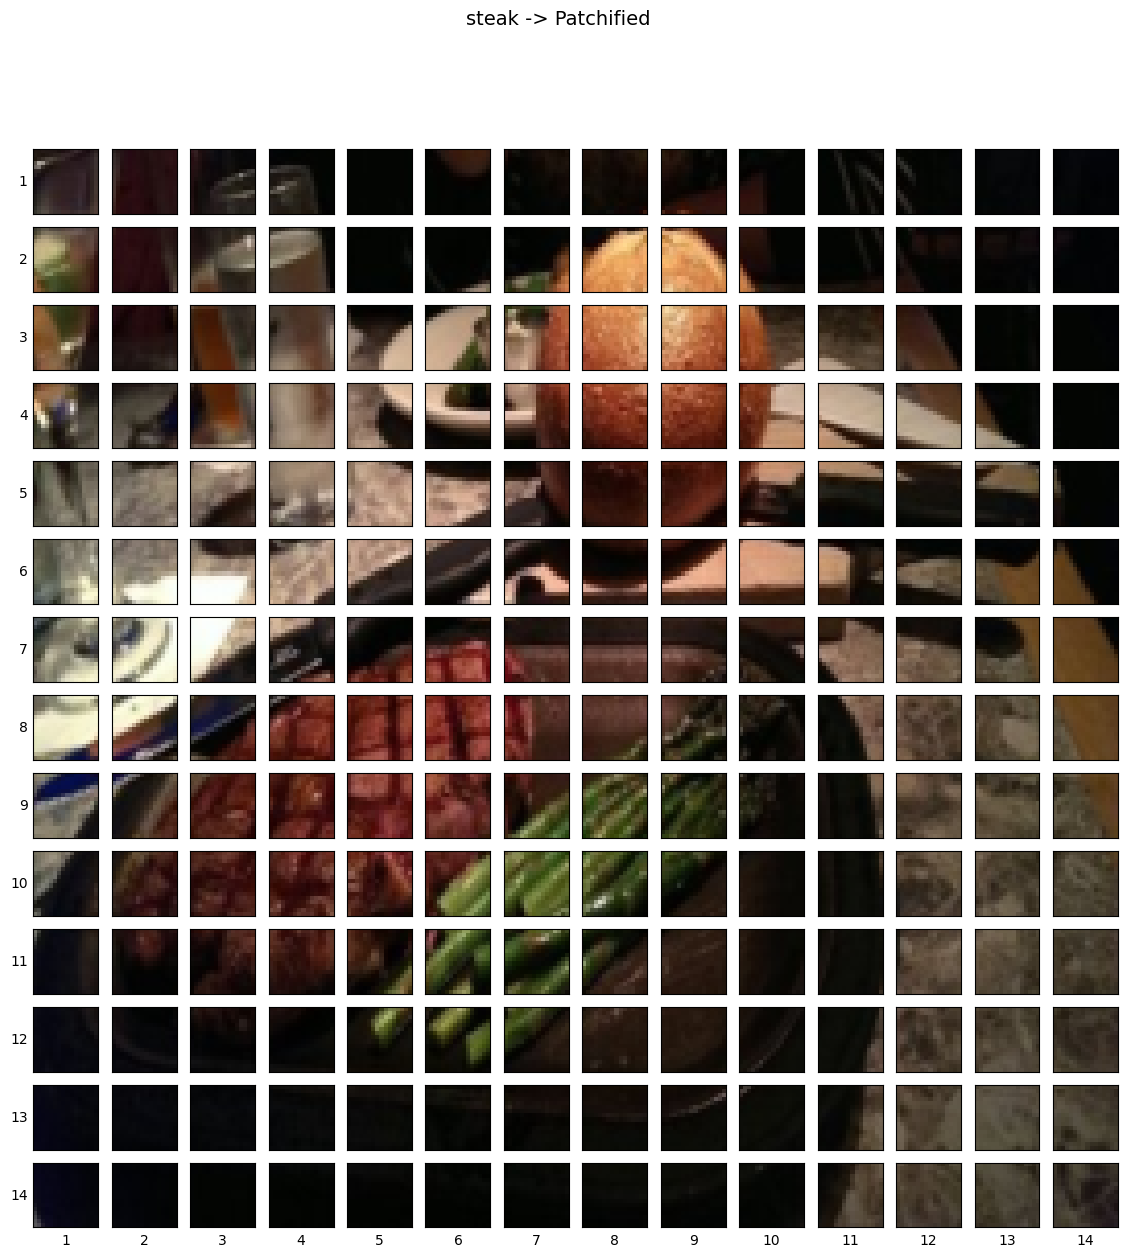

In [23]:
img_size = 224
patch_size = 16
num_patches = int(img_size / patch_size)
assert img_size % patch_size == 0 #image size must be divisible by patch size

print(f"Number of patches per row: {num_patches}\nNumber of patches per column: {num_patches}\nTotal patches: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=int(img_size/patch_size),
                        ncols=int(img_size/patch_size),
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])
        axs[i, j].set_ylabel(i+1,
                             rotation='horizontal',
                             horizontalalignment='right',
                             verticalalignment='center')
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()
        
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

#### Turning patches into patch embeddings
We can convolve over the image to directly create the patch embeddings.
The convolution kernel of patch_size moves over the image creating the embedding for that patch. This gives the feature map, which flattedned to get the input for the encoder.

In [24]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, #3x16^2, 3 channels of 16x16 size patches
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

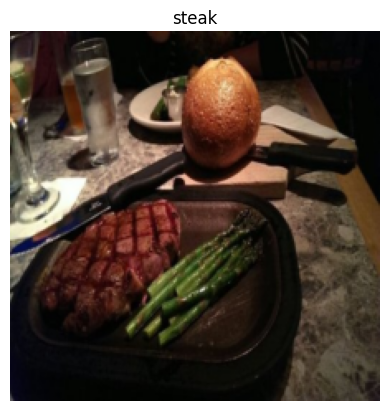

In [25]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [26]:
image_out_of_conv = conv2d(image.unsqueeze(0)) #batch dimension included
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

```
torch.Size([1, 768, 14, 14])
```
[batch_size, embedding_dim, feature_map_height, feature_map_width]

In [27]:
image_out_of_conv.flatten(2,3).shape

torch.Size([1, 768, 196])

Showing random convolution feature map from random indexes: [364, 152, 228, 315, 16]


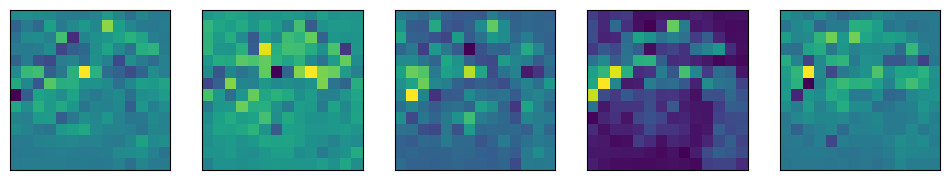

In [28]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolution feature map from random indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [29]:
image_out_of_conv.requires_grad

True

In [30]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.shape, single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

In [31]:
#Flattening the patch embedding
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
image_out_of_conv_flattened.shape

image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
image_out_of_conv_flattened_permuted.shape

torch.Size([1, 196, 768])

In [32]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]
single_flattened_feature_map

tensor([[ 0.1360,  0.0206,  0.0279,  0.0438,  0.0202,  0.0731,  0.0496,  0.0378,
         -0.0108,  0.0105,  0.0457,  0.0271,  0.0271,  0.0224,  0.1277,  0.0307,
          0.1540,  0.0745,  0.0216, -0.0880, -0.0405,  0.0718, -0.0361,  0.0326,
          0.0138,  0.0246,  0.0192,  0.0228,  0.1373,  0.0068,  0.0312,  0.1470,
         -0.0976,  0.3653,  0.1187,  0.2571,  0.1541, -0.1404,  0.0620, -0.0179,
          0.0175,  0.0199,  0.1320,  0.0988,  0.0746,  0.1179,  0.4537,  0.2279,
          0.0708,  0.0901,  0.1055,  0.2637,  0.4546, -0.0090,  0.0576,  0.0215,
          0.1360,  0.1414,  0.4124,  0.3062,  0.1903,  0.1685,  0.0896,  0.0060,
          0.0624,  0.3022,  0.2646,  0.0973,  0.2085,  0.0098,  0.2210,  0.1587,
          0.0793,  0.4341,  0.3950, -0.0805,  0.0496, -0.0620,  0.1600,  0.2930,
         -0.0108,  0.0747, -0.0034, -0.0051,  0.1783,  0.4144,  0.5220,  0.0828,
         -0.0234, -0.0895,  0.0103,  0.0768,  0.0193,  0.1275,  0.0317,  0.0073,
          0.1345,  0.0036,  

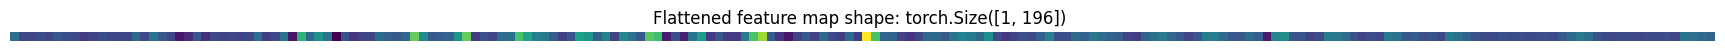

In [33]:
plt.figure(figsize=(22,22))
plt.axis(False)
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape} ")
plt.imshow(single_flattened_feature_map.detach().numpy());

In [34]:
#Creating the patch embedding layer by combining the 2d Conv and flatten layers

patch_embedding_layer = nn.Sequential(nn.Conv2d(in_channels=3,
                                                out_channels=768, #3x16^2, 3 channels of 16x16 size patches
                                                kernel_size=patch_size,
                                                stride=patch_size,
                                                padding=0),
                                      nn.Flatten(start_dim=2, end_dim=3))

#### Creating the Patch embedding layer

In [35]:
# class PatchEmbedding(nn.Module):
    
#     def __init__(self,
#                  in_channels:int=3,
#                  patch_size: int=16,
#                  emebedding_dim: int=768):
        
#         super().__init__()
        
#         self. patch_embedding_layer = nn.Sequential(nn.Conv2d(in_channels=3,
#                                                               out_channels=768, #3x16^2, 3 channels of 16x16 size patches
#                                                               kernel_size=patch_size,
#                                                               stride=patch_size,
#                                                               padding=0),
#                                                     nn.Flatten(start_dim=2, end_dim=3))
    
#     def forward(self, x):
#         x = self.patch_embedding_layer(x)
#         return x

In [36]:
class PatchEmbedding(nn.Module):
    
    def __init__(self,
                 in_channels:int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim 
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size ==0, f"Image resolution must be divisible by patch size."
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)

In [37]:
set_seeds()

In [38]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Patch embedded image: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Patch embedded image: torch.Size([1, 196, 768])


In [39]:
# rand_image_tensor = torch.randn(1,3,200,200)
# patchify(rand_image_tensor)

#### Creating the class token embedding
Prepending a learnable class token to the start of the patch embedding

In [40]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [41]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [42]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) #Using tensor of ones to be visible easily
class_token.shape

torch.Size([1, 1, 768])

In [43]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [44]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2219,  0.0091, -0.0890,  ...,  0.1649, -0.1090,  0.0569],
         [-0.1013, -0.0246, -0.0188,  ...,  0.0522, -0.0791,  0.0524],
         ...,
         [-0.2437,  0.0573, -0.0667,  ...,  0.1920, -0.1272,  0.0842],
         [-0.2986,  0.0253, -0.0815,  ...,  0.2077, -0.1146,  0.0922],
         [-0.1498,  0.0034, -0.1009,  ...,  0.1006, -0.1041,  0.1337]]],
       grad_fn=<CatBackward0>)

#### Creating the position embedding
1D learnable position embeddings to be added to the sequence of patch embeddings

In [45]:
number_of_patches = int((height*width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

#Learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                 requires_grad=True)
position_embedding.shape, position_embedding

(torch.Size([1, 197, 768]),
 Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True))

In [46]:
# Adding the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [47]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7781, 1.0091, 0.9110,  ..., 1.1649, 0.8910, 1.0569],
         [0.8987, 0.9754, 0.9812,  ..., 1.0522, 0.9209, 1.0524],
         ...,
         [0.7563, 1.0573, 0.9333,  ..., 1.1920, 0.8728, 1.0842],
         [0.7014, 1.0253, 0.9185,  ..., 1.2077, 0.8854, 1.0922],
         [0.8502, 1.0034, 0.8991,  ..., 1.1006, 0.8959, 1.1337]]],
       grad_fn=<AddBackward0>)

In [48]:
torch.count_nonzero(patch_and_position_embedding) #just checking

tensor(151296)

In [49]:
1*197*768 #just checking

151296

#### Putting it all together: from image to embedding

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
set_seeds()

In [51]:
patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# Create patch embedding
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token shape: {class_token.shape}")

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create and add position embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#### The MSA Block (Multi Headed Self Attention)
[Good explanation of intuition behind multi head attention and transformers](
https://www.youtube.com/watch?v=g2BRIuln4uc)

In [52]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 attn_dropout: int=0):
        
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) #Because input is of the shape (batch, # of patches, embed dim) i.e. (batch, sequence, features)
    def forward(self, x):
        x = self.layer_norm(x)
        #attn_output, attn_output_weights = multihead_attn(query, key, value)
        attn_output, _ = self.multihead_attn(query=x, #q,k and v are same because self attention
                                             key=x,
                                             value=x,
                                             need_weights=False)
        
        return attn_output

In [53]:
#Create and MSA block instance
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position embedding
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
patch_and_position_embedding.shape, patched_image_through_msa_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [54]:
patched_image_through_msa_block

tensor([[[-0.1432, -0.0537,  0.0476,  ..., -0.3806,  0.8179, -0.4279],
         [-0.1309, -0.0431,  0.0747,  ..., -0.3629,  0.8350, -0.4339],
         [-0.1295, -0.0647,  0.0555,  ..., -0.3690,  0.8306, -0.4568],
         ...,
         [-0.1253, -0.0416,  0.0622,  ..., -0.3756,  0.8368, -0.4444],
         [-0.1157, -0.0379,  0.0614,  ..., -0.3831,  0.8393, -0.4411],
         [-0.1102, -0.0429,  0.0705,  ..., -0.3833,  0.8358, -0.4407]]],
       grad_fn=<TransposeBackward0>)

In [55]:
#Multilayer Perceptron (MLP Block)
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 mlp_size: int=3072,#Check how this was caculated
                 dropout: float=0.1): #From the paper, table 3
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim,
                                           out_features=mlp_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=mlp_size,
                                           out_features=embedding_dim), #Going back to embedding dimension
                                 nn.Dropout(p=dropout)
                                )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [56]:
mlp_block = MLPBlock()

In [57]:
mlp_block

MLPBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
)

In [58]:
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_image_through_msa_block.shape, patched_image_through_mlp_block.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

In [59]:
patched_image_through_msa_block

tensor([[[-0.1432, -0.0537,  0.0476,  ..., -0.3806,  0.8179, -0.4279],
         [-0.1309, -0.0431,  0.0747,  ..., -0.3629,  0.8350, -0.4339],
         [-0.1295, -0.0647,  0.0555,  ..., -0.3690,  0.8306, -0.4568],
         ...,
         [-0.1253, -0.0416,  0.0622,  ..., -0.3756,  0.8368, -0.4444],
         [-0.1157, -0.0379,  0.0614,  ..., -0.3831,  0.8393, -0.4411],
         [-0.1102, -0.0429,  0.0705,  ..., -0.3833,  0.8358, -0.4407]]],
       grad_fn=<TransposeBackward0>)

In [60]:
patched_image_through_mlp_block

tensor([[[ 0.0372, -0.0083,  0.0933,  ..., -0.0000, -0.1068,  0.2385],
         [ 0.0349, -0.1132,  0.2143,  ..., -0.1222, -0.1093,  0.2396],
         [ 0.0899, -0.0783,  0.2250,  ..., -0.0000, -0.1678,  0.2151],
         ...,
         [-0.0819, -0.0118,  0.2082,  ...,  0.0607, -0.1788,  0.3187],
         [-0.0185,  0.0561,  0.0000,  ...,  0.0483, -0.1438,  0.1062],
         [ 0.0241, -0.0114,  0.1953,  ..., -0.1412, -0.1229,  0.2388]]],
       grad_fn=<MulBackward0>)

In [61]:
#Creating the transformer encoder
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0.0):
        super().__init__()
        
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
        
    def forward(self, x):
#         x1 = self.msa_block(x)
#         x2 = x1 + x
#         x3 = self.mlp_block(x2)
#         x4 = x3 + x2
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        
        return x

In [62]:
transformer_encoder_block = TransformerEncoderBlock()

In [63]:
from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1,197,768), #batch, num patches, embedding dimension
        col_names=['input_size', 'output_size','num_params', 'trainable'],
        col_width=15,
        row_settings=["var_names"]
       )

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]   [1, 197, 768]   --              True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─MultiheadAttention (multihead_attn)         --              [1, 197, 768]   2,362,368       True
├─MLPBlock (mlp_block)                             [1, 197, 768]   [1, 197, 768]   --              True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]   [1, 197, 768]   1,536           True
│    └─Sequential (mlp)                            [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─Linear (0)                             [1, 197, 768]   [1, 197, 3072]  2,362,368       True
│    │    └─GELU (1)                               [1, 197,

#### Using Pytorch inbuilt layers to construct the transformer encoder block

In [64]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True
                                                            )

In [65]:
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [66]:
from torchinfo import summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768), #batch, num patches, embedding dimension
        col_names=['input_size', 'output_size','num_params', 'trainable'],
        col_width=15,
        row_settings=["var_names"]
       )

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]   [1, 197, 768]   7,087,872       True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [67]:
#Torchinfo summary does not seem to be giving details of component layers

In [68]:
for name, parameter in torch_transformer_encoder_layer.named_parameters():
    print(f"Name: {name} \tParameters: {parameter.numel()}")

Name: self_attn.in_proj_weight 	Parameters: 1769472
Name: self_attn.in_proj_bias 	Parameters: 2304
Name: self_attn.out_proj.weight 	Parameters: 589824
Name: self_attn.out_proj.bias 	Parameters: 768
Name: linear1.weight 	Parameters: 2359296
Name: linear1.bias 	Parameters: 3072
Name: linear2.weight 	Parameters: 2359296
Name: linear2.bias 	Parameters: 768
Name: norm1.weight 	Parameters: 768
Name: norm1.bias 	Parameters: 768
Name: norm2.weight 	Parameters: 768
Name: norm2.bias 	Parameters: 768


#### Putting it all together to create ViT

In [76]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000): #just leaving 1000 as default as a reference to the original ViT Paper
        super().__init__()
        
        assert img_size%patch_size == 0, f"Image size not divisible by patch size"
        self.num_patches = int((img_size*img_size) / patch_size**2)
        
        #Class and Position Embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        #Patch embedding
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        #Transformer encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        #Creating classifier head, note that only z0 i.e. the zeroth index value is passed to the classifier
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))

    def forward(self, x):
        batch_size = x.shape[0]
        #Create the class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1) #-1 infers the dimension
        
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1) #Concatanating patch embedding #batch_size, number_of_patches+1, embedding_dim
        x = self.position_embedding + x
        
        x = self.embedding_dropout(x)
        
        x = self.transformer_encoder(x)
        
        x = self.classifier(x[:,0])

        return x

In [78]:
#Testing the model with a simple image
set_seeds()

random_image_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=3)

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [79]:
pwd

'/media/pranshumaan/TOSHIBA EXT/Dev/Deep_Learning_Pytorch_Udemy_Tutorial/Paper_Replication'

In [80]:
ls

2010.11929.pdf  data/  going_modular/  helper_functions.py


In [83]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1,3,224,224), #batch, num patches, embedding dimension
        col_names=['input_size', 'output_size','num_params', 'trainable'],
        col_width=15,
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [1, 3, 224, 224] [1, 3]          152,064         True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224] [1, 196, 768]   --              True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
│    └─Flatten (flatten)                                     [1, 768, 14, 14] [1, 768, 196]   --              --
├─Dropout (embedding_dropout)                                [1, 197, 768]   [1, 197, 768]   --              --
├─Sequential (transformer_encoder)                           [1, 197, 768]   [1, 197, 768]   --              True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]   [1, 1